C:\Users\alisher\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - loss: 196.8663 - val_loss: 189.7645
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 189.6674 - val_loss: 182.4578
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 184.1791 - val_loss: 174.6526
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 168.4586 - val_loss: 167.6756
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 166.6103 - val_loss: 162.8129
Epoch 6/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 160.2677 - val_loss: 159.4130
Epoch 7/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 158.9934 - val_loss: 156.9375
Epoch 8/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 157.0683 - val_loss: 155.0698
Epoch 9/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 152.6041 - val_loss: 148.8676
Epoch 10/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 139.1989 - val_loss: 144.1743
Epoch 11/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 143.4933 - val_loss: 136.1106
Epoch 12/50
65/65 ━

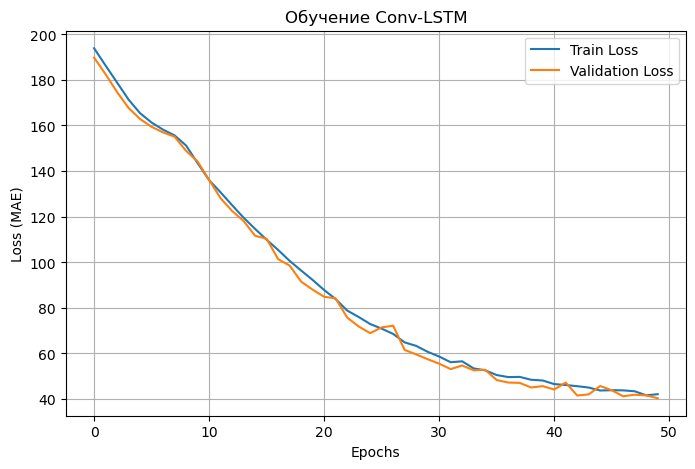

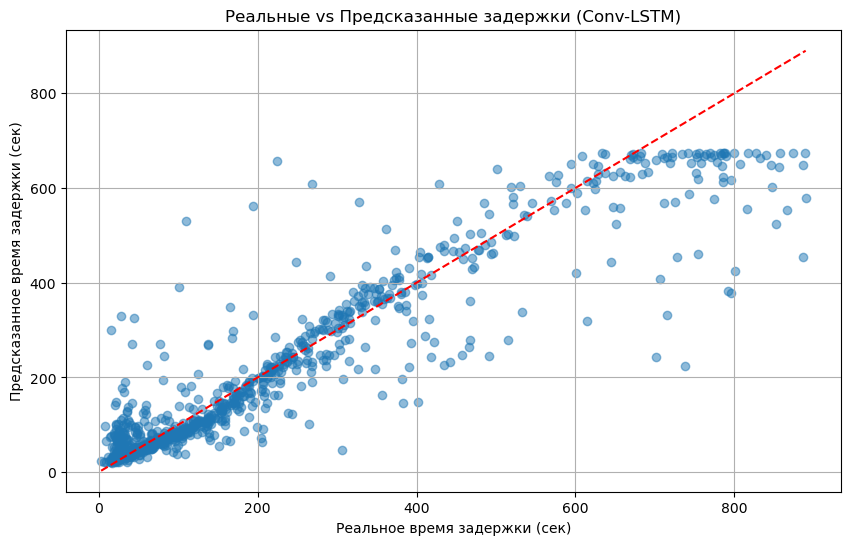

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score

df1 = pd.read_csv('modified.csv')
df2 = pd.read_csv('modified_1.csv')


# === Преобразуем время ===
def convert_datetime(column):
    return pd.to_datetime(column, errors='coerce', format='ISO8601')

df1["bus_board_computer_sent_time"] = convert_datetime(df1["bus_board_computer_sent_time"])
df1["created_time"] = convert_datetime(df1["created_time"])

df2["bus_board_computer_sent_time"] = convert_datetime(df2["bus_board_computer_sent_time"])
df2["created_time"] = convert_datetime(df2["created_time"])

# Удаляем ошибки в данных
df1.dropna(subset=["bus_board_computer_sent_time", "created_time"], inplace=True)

# === Добавляем целевую переменную (время задержки) ===
df1["delay_time"] = (df1["created_time"] - df1["bus_board_computer_sent_time"]).dt.total_seconds()

# === Фильтруем выбросы ===
df1 = df1[df1["delay_time"] < 900]

# === Добавляем признаки ===
df1["day_of_week"] = df1["bus_board_computer_sent_time"].dt.dayofweek
df1["hour"] = df1["bus_board_computer_sent_time"].dt.hour
df1["minute"] = df1["bus_board_computer_sent_time"].dt.minute

# Время суток
def get_time_of_day(hour):
    if 6 <= hour < 12:
        return "morning"
    elif 12 <= hour < 18:
        return "afternoon"
    elif 18 <= hour < 24:
        return "evening"
    else:
        return "night"

df1["time_of_day"] = df1["hour"].apply(get_time_of_day)

# Средние задержки по остановке, маршруту и времени суток
df1["avg_stop_delay"] = df1.groupby("bus_stop_id")["delay_time"].transform("mean")
df1["avg_route_delay"] = df1.groupby("route_number")["delay_time"].transform("mean")

# Скользящее среднее задержки по часам
df1["rolling_avg_hour_delay"] = df1.groupby("hour")["delay_time"].transform(lambda x: x.rolling(5, min_periods=1).mean())
df1["rolling_avg_stop_delay"] = df1.groupby("bus_stop_id")["delay_time"].transform(lambda x: x.rolling(5, min_periods=1).mean())
df1["rolling_avg_route_delay"] = df1.groupby("route_number")["delay_time"].transform(lambda x: x.rolling(5, min_periods=1).mean())

# Добавляем лаговый признак (задержка на предыдущей остановке)
df1["prev_delay_time"] = df1.groupby("bus_stop_id")["delay_time"].shift(1).fillna(df1["delay_time"].mean())

# Заполняемость автобуса и пассажиропоток
df1["bus_load"] = df1["enter_sum"] - df1["exit_sum"]
df1["bus_fill_rate"] = df1["bus_load"] / (df1["tickets_count"] + 1)
df1["passenger_flow"] = df1["enter_sum"] - df1["exit_sum"]

# === Преобразуем категориальные признаки ===
df1 = pd.get_dummies(df1, columns=["time_of_day"], drop_first=True)

# === Формируем X и y ===
X_features = [
    "bus_stop_id", "route_number", "enter_sum", "exit_sum", "tickets_count", 
    "day_of_week", "hour", "minute", "avg_stop_delay", "avg_route_delay", 
    "rolling_avg_hour_delay", "rolling_avg_route_delay", "rolling_avg_stop_delay",
    "bus_load", "bus_fill_rate", "passenger_flow", "prev_delay_time"
]

# Добавляем все one-hot encoding признаки
X_features += [col for col in df1.columns if col.startswith("time_of_day_")]

X = df1[X_features]
y = df1["delay_time"]

# === Масштабируем данные ===
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# === Преобразуем X в 3D-формат для LSTM ===
X_reshaped = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

# === Разделение данных ===
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

# === Построение улучшенной модели Conv-LSTM ===
model = Sequential([
    Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    BatchNormalization(),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# === Компиляция модели ===
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mae')

# === Callbacks (Ранняя остановка) ===
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# === Обучение модели (50 эпох) ===
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=50, batch_size=64, verbose=1, callbacks=[early_stopping])

# === Оценка модели ===
y_pred_lstm = model.predict(X_test)
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
r2_lstm = r2_score(y_test, y_pred_lstm)

print(f"🔹 Финальный MAE (Conv-LSTM): {mae_lstm:.2f} секунд")
print(f"🔹 Финальный R² Score (Conv-LSTM): {r2_lstm:.2%}")

# === Визуализация обучения ===
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (MAE)")
plt.title("Обучение Conv-LSTM")
plt.legend()
plt.grid(True)
plt.show()

# === Визуализация предсказаний ===
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_lstm, alpha=0.5)
plt.xlabel("Реальное время задержки (сек)")
plt.ylabel("Предсказанное время задержки (сек)")
plt.title("Реальные vs Предсказанные задержки (Conv-LSTM)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="--")
plt.grid(True)
plt.show()


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score

df1 = pd.read_csv('modified.csv')
df2 = pd.read_csv('modified_1.csv')


# === Преобразуем время ===
def convert_datetime(column):
    return pd.to_datetime(column, errors='coerce', format='ISO8601')

df1["bus_board_computer_sent_time"] = convert_datetime(df1["bus_board_computer_sent_time"])
df1["created_time"] = convert_datetime(df1["created_time"])

df2["bus_board_computer_sent_time"] = convert_datetime(df2["bus_board_computer_sent_time"])
df2["created_time"] = convert_datetime(df2["created_time"])

# Удаляем ошибки в данных
df1.dropna(subset=["bus_board_computer_sent_time", "created_time"], inplace=True)

# === Добавляем целевую переменную (время задержки) ===
df1["delay_time"] = (df1["created_time"] - df1["bus_board_computer_sent_time"]).dt.total_seconds()

# === Фильтруем выбросы ===
df1 = df1[df1["delay_time"] < 900]

# === Добавляем признаки ===
df1["day_of_week"] = df1["bus_board_computer_sent_time"].dt.dayofweek
df1["hour"] = df1["bus_board_computer_sent_time"].dt.hour
df1["minute"] = df1["bus_board_computer_sent_time"].dt.minute

# Время суток
def get_time_of_day(hour):
    if 6 <= hour < 12:
        return "morning"
    elif 12 <= hour < 18:
        return "afternoon"
    elif 18 <= hour < 24:
        return "evening"
    else:
        return "night"

df1["time_of_day"] = df1["hour"].apply(get_time_of_day)

# Средние задержки по остановке, маршруту и времени суток
df1["avg_stop_delay"] = df1.groupby("bus_stop_id")["delay_time"].transform("mean")
df1["avg_route_delay"] = df1.groupby("route_number")["delay_time"].transform("mean")

# === Новые rolling-фичи (добавляем 15 и 30 минутные задержки) ===
df1["rolling_avg_delay_15min"] = df1.groupby("bus_stop_id")["delay_time"].transform(lambda x: x.rolling(3, min_periods=1).mean())
df1["rolling_avg_delay_30min"] = df1.groupby("bus_stop_id")["delay_time"].transform(lambda x: x.rolling(6, min_periods=1).mean())

# Скользящее среднее задержки по часам
df1["rolling_avg_hour_delay"] = df1.groupby("hour")["delay_time"].transform(lambda x: x.rolling(5, min_periods=1).mean())
df1["rolling_avg_stop_delay"] = df1.groupby("bus_stop_id")["delay_time"].transform(lambda x: x.rolling(5, min_periods=1).mean())
df1["rolling_avg_route_delay"] = df1.groupby("route_number")["delay_time"].transform(lambda x: x.rolling(5, min_periods=1).mean())

# Добавляем лаговый признак (задержка на предыдущей остановке)
df1["prev_delay_time"] = df1.groupby("bus_stop_id")["delay_time"].shift(1).fillna(df1["delay_time"].mean())

# Заполняемость автобуса и пассажиропоток
df1["bus_load"] = df1["enter_sum"] - df1["exit_sum"]
df1["bus_fill_rate"] = df1["bus_load"] / (df1["tickets_count"] + 1)
df1["passenger_flow"] = df1["enter_sum"] - df1["exit_sum"]

# === Преобразуем категориальные признаки ===
df1 = pd.get_dummies(df1, columns=["time_of_day"], drop_first=True)

# === Формируем X и y ===
X_features = [
    "bus_stop_id", "route_number", "enter_sum", "exit_sum", "tickets_count", 
    "day_of_week", "hour", "minute", "avg_stop_delay", "avg_route_delay", 
    "rolling_avg_hour_delay", "rolling_avg_route_delay", "rolling_avg_stop_delay",
    "rolling_avg_delay_15min", "rolling_avg_delay_30min",
    "bus_load", "bus_fill_rate", "passenger_flow", "prev_delay_time"
]

# Добавляем все one-hot encoding признаки
X_features += [col for col in df1.columns if col.startswith("time_of_day_")]

X = df1[X_features]
y = df1["delay_time"]

# === Масштабируем данные ===
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# === Преобразуем X в 3D-формат для LSTM ===
X_reshaped = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

# === Разделение данных ===
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

# === Улучшенная Conv-LSTM модель ===
model = Sequential([
    Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    BatchNormalization(),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# === Компиляция модели ===
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mae')

# === Callbacks (Ранняя остановка) ===
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# === Обучение модели (70 эпох) ===
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=70, batch_size=64, verbose=1, callbacks=[early_stopping])

# === Оценка модели ===
y_pred_lstm = model.predict(X_test)
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
r2_lstm = r2_score(y_test, y_pred_lstm)

print(f"🔹 Финальный MAE (Conv-LSTM): {mae_lstm:.2f} секунд")
print(f"🔹 Финальный R² Score (Conv-LSTM): {r2_lstm:.2%}")


Epoch 1/70


C:\Users\alisher\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 198.0371 - val_loss: 195.8088
Epoch 2/70
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 195.6364 - val_loss: 192.3406
Epoch 3/70
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 193.9839 - val_loss: 190.1622
Epoch 4/70
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 187.0349 - val_loss: 188.4385
Epoch 5/70
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 191.5252 - val_loss: 186.8442
Epoch 6/70
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 191.9196 - val_loss: 185.2864
Epoch 7/70
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 187.3675 - val_loss: 183.7293
Epoch 8/70
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 183.6115 - val_loss: 182.1773
Epoch 9/70
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 169.4650 - val_loss: 180.6330
Epoch 10/70
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 182.8391 - val_loss: 179.0648
Epoch 11/70
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 179.3094 - val_loss: 177.4841
Epoch 12/70
65/65 ━━━━━━━━━━━━